In [1]:
import os
from os import path
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
if not 'BASE_DIR' in locals():
    BASE_DIR = os.path.abspath(os.curdir)

In [2]:
if os.path.abspath(os.curdir) == BASE_DIR:
    os.chdir('../')

dirname = os.path.abspath(os.curdir) + r'\data'
df = pd.read_csv(path.join(os.sep, dirname, 'Annual rainfall in Nottingham castle 1867  1939.csv'))
df = df.drop('Unnamed: 0', axis=1)
df.head()

,x
0,29.90
1,25.33
2,27.75
3,17.93
4,26.83


Проверяем на стационарность

In [3]:
def Fuller(name:str, df:pd.DataFrame):
    alpha = 0.05
    if hasattr(df, 'columns'):
        df = df[df.columns[0]]
    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")
Fuller('Rainfall', df)

Тест Дики-Фуллера ряда Rainfall :
Test Statistic                 -3.383976
p-value                         0.011517
#Lags Used                      2.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Раскладываем ряд

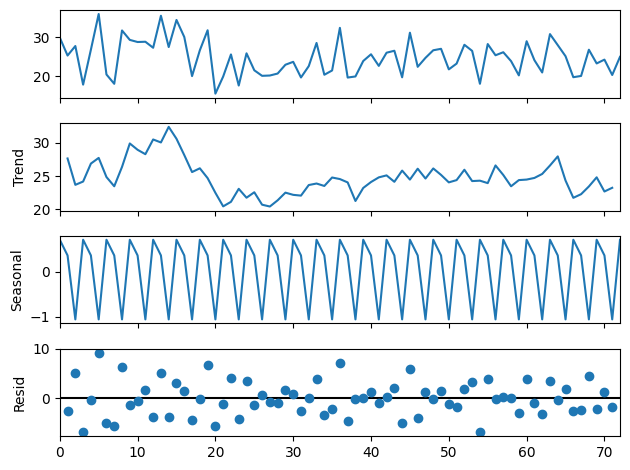

In [4]:
decompose_add = seasonal_decompose(df, model='additive', period=3)
decompose_add.plot()
plt.show()

Тест Дики-Фуллера ряда Rainfall :
Test Statistic                -7.510777e+00
p-value                        4.021093e-11
#Lags Used                     5.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (1%)           -3.535217e+00
Critical Value (5%)           -2.907154e+00
Critical Value (10%)          -2.591103e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


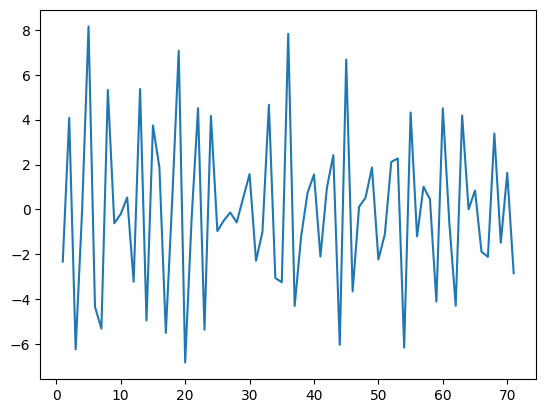

In [5]:
no_trend = decompose_add.seasonal + decompose_add.resid
no_trend.plot()
Fuller('Rainfall', no_trend[1:-1])

Тест Дики-Фуллера ряда Rainfall :
Test Statistic                 -3.107560
p-value                         0.025999
#Lags Used                      2.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


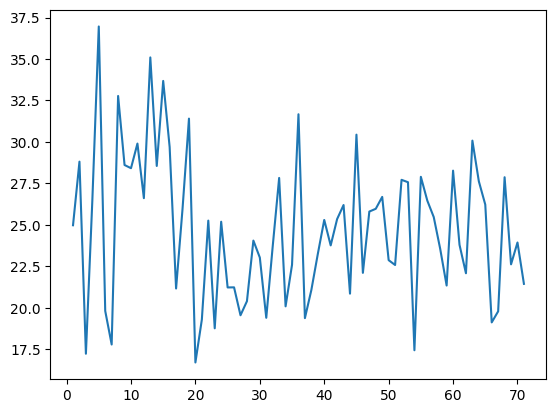

In [6]:
no_season = decompose_add.trend + decompose_add.resid
no_season.plot()
Fuller('Rainfall', no_season[1:-1])

Автокорреляция

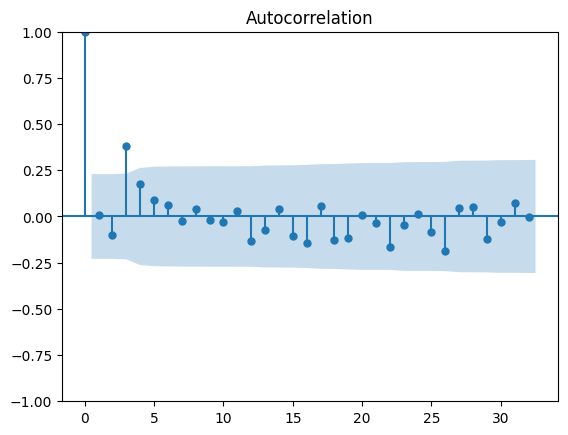

In [7]:
A = smt.graphics.plot_acf(df, lags=32)

Частичная автокорреляция

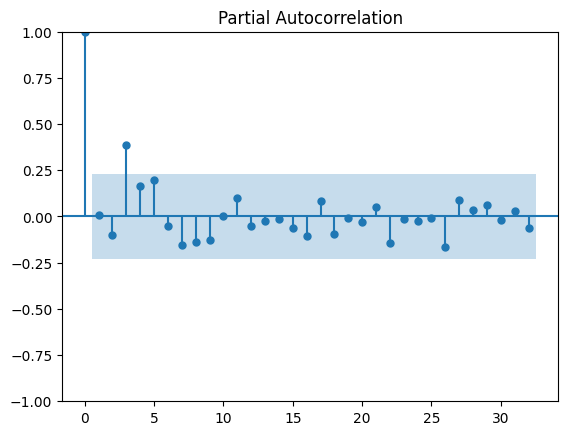

In [8]:
B = smt.graphics.plot_pacf(df, lags=32)

In [9]:
df["t"] = df.index.values
ln = len(df)
train_cutoff = int(round(ln*0.75,0))    # Граница тренировочных данных
validate_cutoff = int(round(ln*0.9,0))  # Граница валидационных данных

train_df = df[df["t"] <= train_cutoff]  # Тренировочные данные
validate_df = df[(df["t"] > train_cutoff) & (df["t"] <= validate_cutoff)]  # Валидационные данные
forecast_df = df[df["t"] > validate_cutoff]  # Данные для предсказания

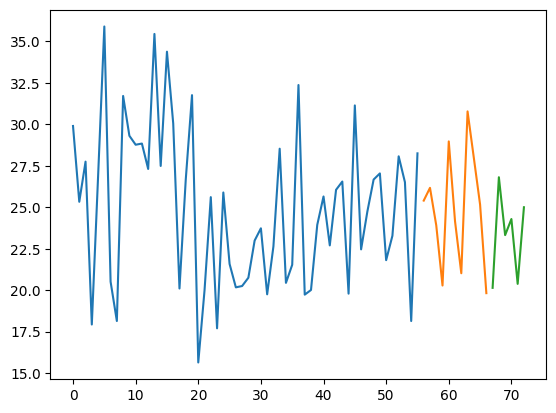

In [10]:
plt.plot(train_df.t,train_df.x,label="Training data")
plt.plot(validate_df.t,validate_df.x,label="Validate data")
plt.plot(forecast_df.t,forecast_df.x,label="for prediction")
plt.show()

In [11]:
sel = ar_select_order(df.x,35,old_names=False)
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   73
Model:                    AutoReg(35)   Log Likelihood                 -16.793
Method:               Conditional MLE   S.D. of innovations              0.376
Date:                Thu, 29 Feb 2024   AIC                            107.586
Time:                        22:19:42   BIC                            168.177
Sample:                            35   HQIC                           129.144
                                   73                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.0071     12.063      7.379      0.000      65.364     112.650
x.L1          -0.3864      0.057     -6.741      0.000      -0.499      -0.274
x.L2           0.3928      0.084      4.697      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


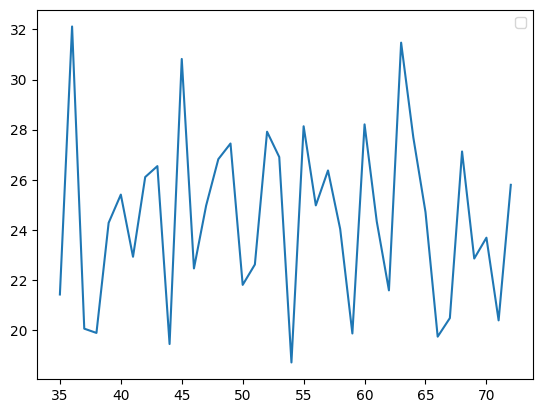

In [12]:
fig = res.plot_predict(0)

In [13]:
pred = res.predict(start=0,end=train_cutoff,dynamic=False)
v_pred = res.predict(start=train_cutoff+1,end=validate_cutoff,dynamic=False)
f_pred = res.predict(start=validate_cutoff+1,end=(forecast_df.t[len(df.t)-1]))

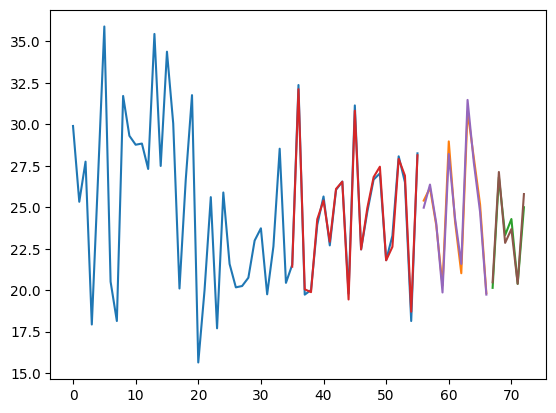

In [14]:
plt.plot(train_df.t,train_df.x,label="Training data")
plt.plot(validate_df.t,validate_df.x,label="Validate data")
plt.plot(forecast_df.t,forecast_df.x,label="for prediction")
plt.plot(train_df.t,pred,label="Training prediction")
plt.plot(validate_df.t,v_pred,label="Validate prediction")
plt.plot(forecast_df.t,f_pred,label="Forecast prediction")

In [15]:
def SMAPE(y_true, y_pred):
    numerator = np.abs(y_true-y_pred)
    denumerator = (np.abs(y_true) + np.abs(y_pred))/2
    res = numerator/denumerator
    res = np.sum(res)
    res *= 100
    res /= len(y_true)
    return res

In [16]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))
print("SMAPE", SMAPE(forecast_df.x, f_pred))

RMSE: 0.48828430854986726
MAPE: 0.01756778840167181
MAE: 0.4205905918831476
R2:  0.9587735769412631
SMAPE 1.7536752945744463
